# 3. Test

In [1]:
import sys, os
import pandas as pd
sys.path.append("../../../../")

from Clust.setting import influx_setting_KETI as ins
from Clust.clust.ingestion.influx import influx_client_v2 as influx_Client
from Clust.clust.ingestion.mongo.mongo_client import MongoClient
db_client = influx_Client.InfluxClient(ins.CLUSTDataServer2)
mongo_client = MongoClient(ins.CLUSTMetaInfo2)

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cpu is available.


In [2]:
from Clust.clust.ML.common import ML_pipeline, tool

## 1. Data Preparation

In [3]:
app_name= "Hs2SwineFarmWithWeatherTime" # "Hs2SwineFarmWithWeatherTime", "energy"
model_method = 'GRU_rg'
model_clean = True
step = 'test'
bucket_name = 'integration'
# data_clean_level=0

In [4]:
model_name = None
model_name = tool.get_default_model_name(model_name, app_name, model_method, model_clean)
collection_name = 'meta'
db_name = 'model'
model_meta_list= mongo_client.get_document_by_json(db_name, collection_name, {'modelName': model_name})
model_meta = model_meta_list[0] ## ??

In [50]:
model_meta

{'trainDataInfo': {'bucket_name': 'integration',
  'ms_name': 'forecasting_Hs2SwineFarmWithWeatherTime_cleanLevel4_trainX',
  'ingestion_type': 'multiple_ms_by_time',
  'ingestion_param': {'start_time': '2021-02-01 00:00:00',
   'end_time': '2021-03-10 00:00:00',
   'ms_list_info': [['farm_swine_air', 'HS2'],
    ['weather_outdoor_keti_clean', 'sangju'],
    ['life_additional_Info', 'trigonometicInfoByHours']]},
  'processing_type': 'step_3',
  'process_param': {'refine_param': {'removeDuplication': {'flag': True},
    'staticFrequency': {'flag': True, 'frequency': None}},
   'outlier_param': {'certainErrorToNaN': {'flag': True},
    'unCertainErrorToNaN': {'flag': True,
     'param': {'outlierDetectorConfig': [{'algorithm': 'IQR',
        'percentile': 99,
        'alg_parameter': {'weight': 100}}]}}},
   'imputation_param': {'flag': True,
    'imputation_method': [{'min': 0,
      'max': 2,
      'method': 'linear',
      'parameter': {}}],
    'totalNonNanRatio': 90}},
  'integratio

### 1-2. Data Ingestion
#### 1-2-1. X-y Data Ingestion pipeline

In [5]:
model_purpose = model_meta['modelPurpose']
dataset_name = model_purpose + '_' + app_name  
scaler_param= model_meta['scalerParam']
data_name_X = dataset_name + '_cleanLevel' + str(data_clean_level)+'_'+step+'X'
data_name_y = dataset_name+'_cleanLevel' + str(data_clean_level)+'_'+ step+'y'
data_y_flag = model_meta['data_y_flag']

In [6]:
feature_X_list = model_meta['featureXList']
feature_y_list = model_meta["featureyList"]
model_file_path = model_meta['files']['modelFile']["filePath"]

In [7]:
# Data Ingestion
ingestion_method = 'ms_all'
ingestion_param_X = {
    "bucket_name" : bucket_name,
    'ms_name' : data_name_X,
    'feature_list' : feature_X_list                              
}
ingestion_param_y = {
    "bucket_name" : bucket_name,
    'ms_name' : data_name_y,
    'feature_list' : feature_y_list                              
}

In [8]:
data_X, data_y = ML_pipeline.Xy_data_preparation(ingestion_param_X, data_y_flag, ingestion_param_y, ingestion_method, db_client)

#### 1-2-2. Random Nan Insert (Test)
#### 1-2-3. Data scaling

In [9]:
X_scaler_file_path = model_meta['files']['XScalerFile']["filePath"]
y_scaler_file_path = model_meta['files']['yScalerFile']["filePath"]
y_scaler_file_path

'./scaler/forecasting_Hs2SwineFarmWithWeatherTime_cleanLevel4_trainy/minmax/2ef658edf359871df2a5d6f044a18200/scaler.pkl'

In [10]:
scaler_param = model_meta["scalerParam"]
test_X, scaler_X , test_y, scaler_y  = ML_pipeline.Xy_data_scaling_test(data_X, data_y, X_scaler_file_path, y_scaler_file_path, scaler_param)

#### 1-2-2. Random Nan Insert (Test X)
#### 1-2-3. Data scaling

In [11]:
split_mode = model_meta['dataSplitMode']
transformParameter = model_meta["transformParameter"]
test_X_array, test_y_array = ML_pipeline.transform_data_by_split_mode(split_mode, transformParameter, test_X, test_y)

nan_limit_num:  6
Original num: 1003 Final num: 989 NaN num: 14


In [12]:
modelParameter = model_meta["modelParameter"]

testParameter = {
    'device': 'cpu',
    'batch_size': model_meta["trainParameter"]['batch_size']
}

In [13]:
#3. Test model
preds, trues = ML_pipeline.CLUST_regresstion_test(test_X_array, test_y_array, testParameter, model_method, model_file_path, modelParameter)

features shape: torch.Size([989, 12, 3]) targets shape:  torch.Size([989, 1])

Start testing data



In [17]:
print(test_X_array.shape, test_y_array.shape)
print(preds.shape, trues.shape)
target = feature_y_list[0]
scaler, feature_list = ML_pipeline.get_scaler_information_by_y_flag(data_y_flag, scaler_X, scaler_y, feature_X_list, feature_y_list)
df_result, result_metrics = ML_pipeline.get_final_metrics(preds, trues, scaler_param, scaler, feature_list, target)

(989, 12, 3) (989, 1)
(976,) (976,)
scale


         value  prediction
0    25.380000   25.338971
1    25.580000   25.457777
2    25.740000   25.576841
3    25.860000   25.713833
4    26.040000   25.858994
..         ...         ...
971  20.140000   20.583612
972  20.200001   20.565372
973  20.220000   20.412091
974  20.220000   20.375525
975  19.940001   20.375148

[976 rows x 2 columns]
{'mae': 0.4131571050794397, 'rmse': 0.5444710179979978, 'r2': 0.9245402849656444, 'mape': 1.6730402197174126}


<AxesSubplot:>

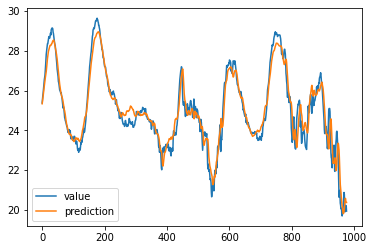

In [18]:
print(df_result)
print(result_metrics)
df_result.plot()

In [ ]:
# 5. Only For IPython Notebook
#from Clust.clust.tool.plot.plot_two_data import plot_predictions
#import plotly.offline as pyo
# Set notebook mode to work in offline
#pyo.init_notebook_mode()
#plot_predictions(df_result)